# Capture and treatment of satellite images

The module **tiff_downloader** is used to capture and process satellite images in an easy and convenient way. Additionally, it is possible to combine raster data with shapefiles layers to get more insightful images. The module **shapefile_module** is responsible for this part. We will be working with the file *RJ_Mun97_region.shp*, which can be downloaded at [this link](http://www.ipea.gov.br/ipeageo/malhas.html). This is the the map of the state *Rio de Janeiro*.

## 1. Extract information from the shapefile

In [1]:
import glob
import os
import numpy as np
import rasterio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import timedelta
import tiff_downloader as td
import shapefile_module as shpm

%matplotlib inline

In [2]:
# Set the filepath and load in a shapefile.
shp_path = "RJ_Mun97_region/RJ_Mun97_region.shp"
map_df = gpd.read_file(shp_path)
map_df.head()

CODMUN6   MUNIC_PIO  SEM_ACENTO MUNIC_PI0  UF UF_IBGE REGI_O  \
0  330380      PARATI      PARATI    330380  RJ      33     SE   
1  330420     RESENDE     RESENDE    330420  RJ      33     SE   
2  330225    ITATIAIA    ITATIAIA    330225  RJ      33     SE   
3  330411  PORTO REAL  PORTO REAL    330411  RJ      33     SE   
4  330440   RIO CLARO   RIO CLARO    330440  RJ      33     SE   

        MESO_IBGE MESO_IBG0                  MICRO_IBGE MICRO_IB0 MESO_IBG1  \
0  SUL FLUMINENSE        05         BAIA DA ILHA GRANDE       013      3305   
1  SUL FLUMINENSE        05  VALE DO PARAIBA FLUMINENSE       011      3305   
2  SUL FLUMINENSE        05  VALE DO PARAIBA FLUMINENSE       011      3305   
3  SUL FLUMINENSE        05  VALE DO PARAIBA FLUMINENSE       011      3305   
4  SUL FLUMINENSE        05  VALE DO PARAIBA FLUMINENSE       011      3305   

  MICRO_IB1    AREA_97    SEDE   SEDE0      N91        N96       CODCOMP  \
0    330513   928.4739 -44.713 -23.218  24525.0  1003699.0  330501303807   
1    330511  1113.4390 -44.447 -22.469  94307.0    93961.0  330501104201   
2    330511   224.9654 -44.563 -22.496  16711.0    21216.0  330501102254   
3    330511    50.6217 -44.290 -22.420      0.0     8664.0  330501104110   
4    330511   841.3873 -44.136 -22.723  13724.0    14449.0  330501104409   

                                            geometry  
0  POLYGON ((-44.882774 -23.202152, -44.881471 -2...  
1  POLYGON ((-44.809182 -22.404622, -44.807389 -2...  
2  POLYGON ((-44.660729 -22.377752, -44.659369 -2...  
3  POLYGON ((-44.332514 -22.4912, -44.34302 -22.4...  
4  POLYGON ((-44.320076 -22.845306, -44.318847 -2...

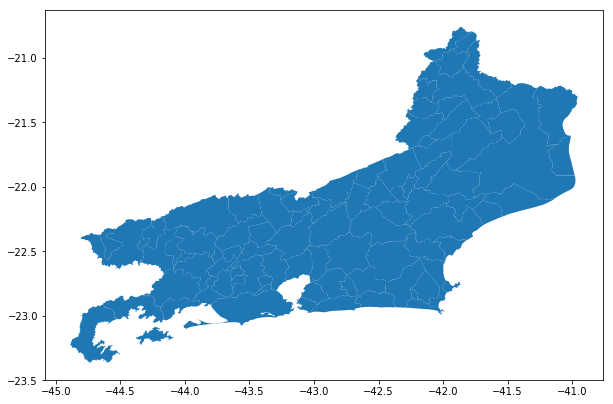

In [3]:
# Plot whole shapefile.
map_df.plot(figsize=[10,10])

In the module **shapefile_module** there is the function **extract_shp_boundingbox**, we use it to extract the bounding box of a shapefile. The outputs of this function are *point1* and *point2*, where *point1* is the top left point and *point2* is the bottom right point. These are spatial coordinates in the system epsg:4326. The program makes the change of coordinate automatically if the original shapefile is using another system so you don't need to worry about it.
This module always use the second column ('MUNIC_PIO' in this case) as labels for each one of the polygons. Thus we advise to use a shapefile such that the labels of the second column are all distinct between each other. Otherwise the program will encounter ambiguity, which may lead to errors.

In [4]:
# Extract bounding box from shapefile.
point1, point2 = shpm.extract_shp_boundingbox(shp_path)
print('point 1 =', point1)
print('point 2 =', point2)

point 1 = [-44.88834, -20.763056]
point 2 = [-40.957431, -23.367102]


## 2. Download and work with satelite images

The main function of the module **tiff_downloader** is called **download_tiffs**, and it has the following parameters as input: 

                    source, date1, date2, point1, point2, opt
                    
 - *source* can be any one of the names mentioned when we call the function **about** with *sources* as input. For example 'LandDAAC-v5-day' is a valid source parameter. 
 
 - *date1* and *date2* are the initial date and final date we are interested in. If the source gets images in a frequence of 8 days for example, then the program will download all images following this frequence and between *date1* and *date2*. 
 
 - *point1* is a tuple (x, y), corresponding to the top left point of the image, while *point2* corresponds to the bottom right point. 
 - *opt* is a dictionary with all optional variables of interest. These variables are described in the function **about** with the argument *options*. If nothing is passed to *opt*, then the program just download the images in their original format. 

Below we show a example passing the option 'regrid' to get a bigger size (5 times bigger in each dimension), using the bilinear method and plotting the images on the screen. We choose to download the images from LandDAAC-v5-day, from 2016-jul-20 to 2016-jul-28. Since this source generates 1 file each 8 days, this means we are actually downloading only 1 file.  

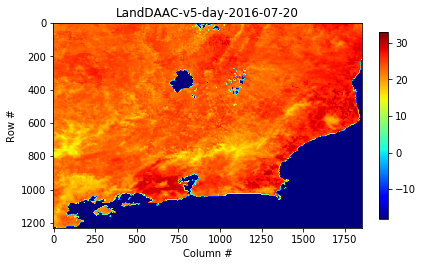

In [5]:
# Download raster data.
source = 'LandDAAC-v5-day'
date1 = ['2016', '07', '20']
date2 = ['2016', '07', '28']
options = {'plot': True, 'keep_original': True, 'regrid': [5, 'bilinear']}

td.download_tiffs(source, date1, date2, point1, point2, opt=options)

Some additional features are the following:

**1)** The colormap can be passed as an option inside the class of options. It must be a string with a valid colormap name. 

**2)** Sometimes you don't need to save the original files, only the treated ones. Instead of downloading them and deleting manually, you can just set the option *keep_original* to False. This parameter is part of the dictionary *options*. 

**3)** After all downloads are completed, it may be interesting to use some tool (here we use Geoviews) to interact with the time series. This is possible when the option *time_series* is set to True.

**4)** Maybe you want to visualize the time series of some data already in your computer. The default filename to be read by the program is *time_series.nc*. The function responsible for visualizing time series is called **view_time_series**, and you only need to pass the file name as argument. 

**5)** Plot the time series of individual points and average pixel per polygon.

**Attention:** to use interactivity the time interval must be within the same year. Changing the year causes an error.   

We can combine the raster file just downloaded with the shapefile. To see how they match, we combine the first untreated raster file *LandDAAC-v5-day-2016-07-20.tiff* with the shapefile. In this example we assume all the downloaded files are in a folder called *DownloadedFiles*. The location where the downloaded files goes should be written in the file *settings.ini* (write the full path in this file).

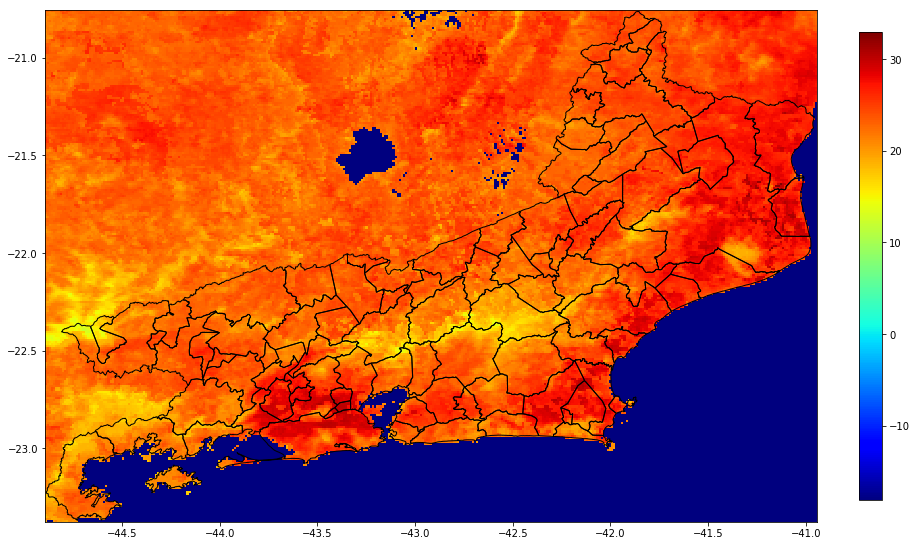

In [6]:
raster_path = "DownloadedFiles/LandDAAC-v5-day-2016-07-20.tiff"
shpm.raw_plot(shp_path, raster_path, cmap='jet')

Below we show the treated raster file *LandDAAC-v5-day-2016-07-20-treated.tiff* with the same shapefile. The difference is not so much noticeable since the image is already, but it is possible to note that the treated image is more smooth.

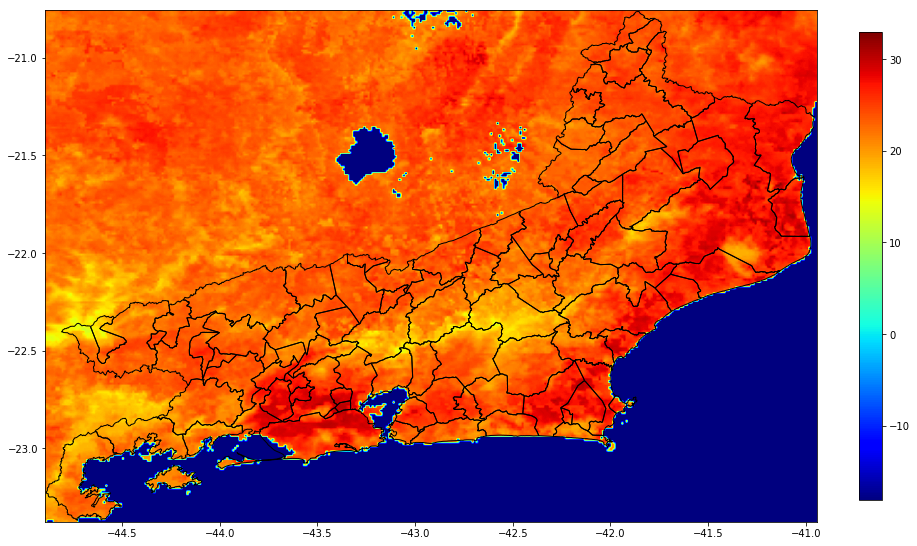

In [7]:
raster_path = "DownloadedFiles/LandDAAC-v5-day-2016-07-20-treated.tiff"
shpm.raw_plot(shp_path, raster_path, cmap='jet')

Now we want to compute the average pixel with respect to each polygon, i.e., the average of the pixels inside a polygon. After doing that for all polygons, we can make a new plot, showing only the colors of the respective averages.

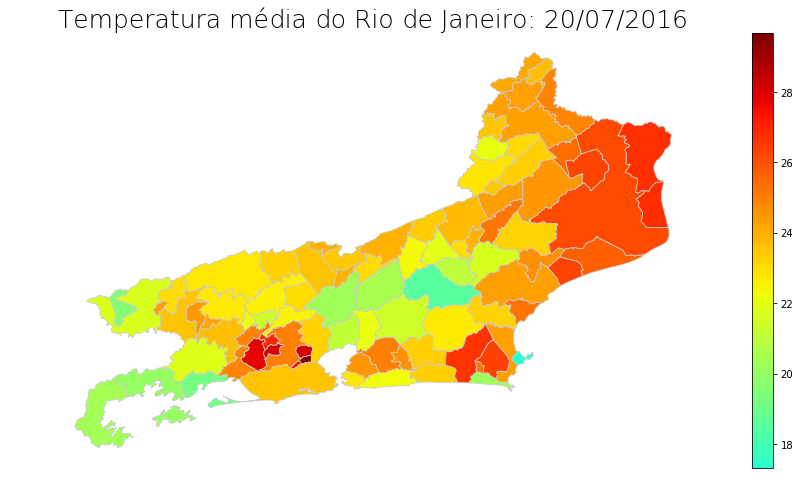

In [8]:
z_means = shpm.zonal_means(shp_path, raster_path)
shpm.zonal_plot(shp_path, z_means, 'Temperatura média do Rio de Janeiro: 20/07/2016', cmap='jet')

## 3. Interactivity

It is possible to enable interactivity with Geoviews. For this we'll need to download several raster files in sequence. In this example we are downloading the land temperature at night from july-01 of 2016 to october-30 2016 (three entire months), with a frequency of 8 days. 

To construct the time series, all files in the folder *DownloadedFiles* are merged. Thus it is necessary to leave that folder empty and to set *keep_original* to *False* before calling the function with *time_series = True*.

**Warning**: there are some [issues](https://github.com/pydata/xarray/issues/2535) between rasterio and NetCDF so I recommend to restart the kernel after using any function with interactivity as below.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
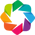

:HoloMap   [band,time]
   :Image   [x,y]   (__xarray_dataarray_variable__)

In [9]:
# Download more files so we have a reasonable dataset to explore with Geoviews.
source = 'LandDAAC-v5-night'
date1 = ['2016', '07', '20']
date2 = ['2016', '10', '30']
options = {'regrid': [5, 'cubic'], 'plot': False, 'keep_original': False, 'time_series': True, 'cmap': 'seismic'}
    
td.download_tiffs(source, date1, date2, point1, point2, opt=options)

The interactive display is opened right after the downloads are made. If for some reason you closed the notebook and want to use same interactivity again, call the function **view_time_series**. This function will read the time series (stored in the file *time_series.nc*) and reopen the interactive session.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
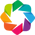

:HoloMap   [band,time]
   :Image   [x,y]   (__xarray_dataarray_variable__)

In [10]:
# Use the function 'view_time_series' to view any time series already downloaded.
td.view_time_series('DownloadedFiles/time_series.nc', cmap='inferno')

## 4. Plots of time series

At each timestamp we have a raster file from which we can extract averages. In particular, one can choose some cities (polygons of the shapefile) and visualize the time series of its averages. The function **time_series** computes the sequence of averages (as showed with the function **zonal_plot**) for a certain polygon, which should be referred by its name in the second column of the shapefile. Below we show an example of usage of this function.

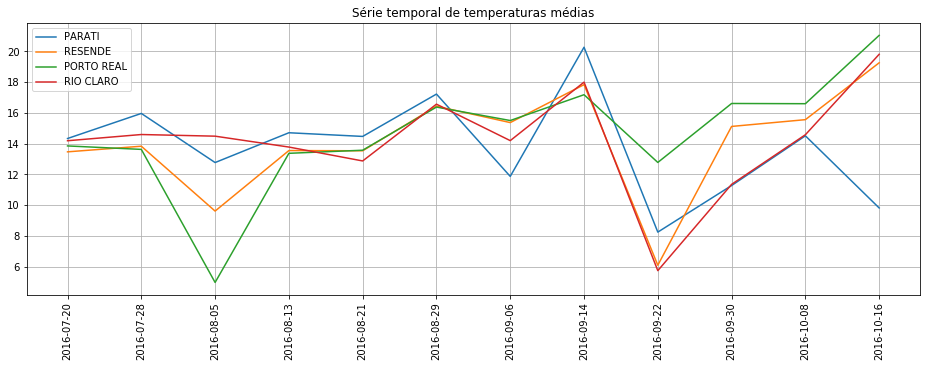

In [10]:
# Create list with all tiff filenames in alphabetical order.
filenames = glob.glob('DownloadedFiles/*.tiff')
filenames.sort()

# Create time series of some boroughs in the sequence of raster data 
t_series1, dates = shpm.time_series(shp_path, filenames, 'PARATI', plot=False)
t_series2, dates = shpm.time_series(shp_path, filenames, 'RESENDE', plot=False)
t_series3, dates = shpm.time_series(shp_path, filenames, 'PORTO REAL', plot=False)
t_series4, dates = shpm.time_series(shp_path, filenames, 'RIO CLARO', plot=False)

# Plot time series
plt.figure(figsize=[16, 5])
plt.plot(dates, t_series1, label='PARATI')
plt.plot(dates, t_series2, label='RESENDE')
plt.plot(dates, t_series3, label='PORTO REAL')
plt.plot(dates, t_series4, label='RIO CLARO')
title = 'Série temporal de temperaturas médias'
plt.title(title)
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.show()

The function **point_time_series** plots the time series evolution with respect to the row-column coordinate of the array image. 

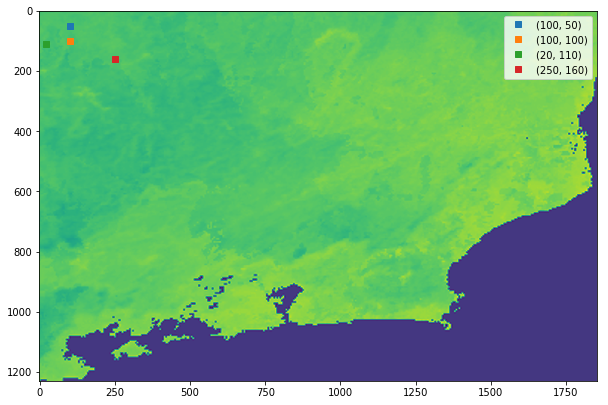

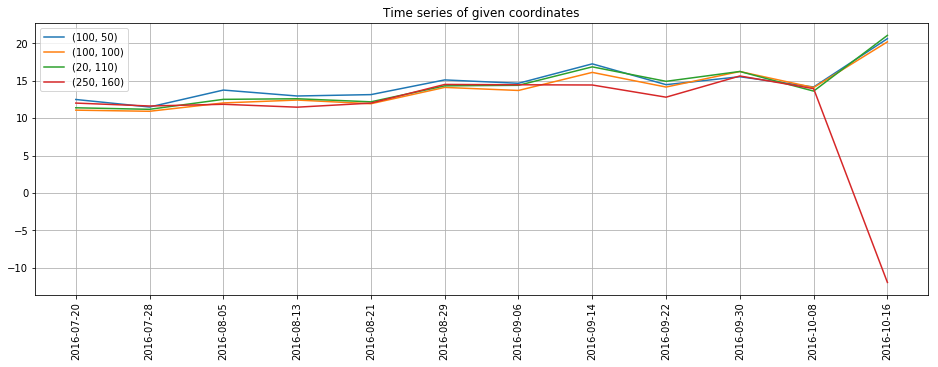

In [11]:
points = [[100, 50], [100, 100], [20, 110], [250, 160]]
info = td.point_time_series(points, spatial_coordinates=False)

If desired, it is possible to pass spatial coordinates to the function. In this case set the optional parameter 'spatial_coordinates' to True. One can make the same plot using spatial coordinates instead. 

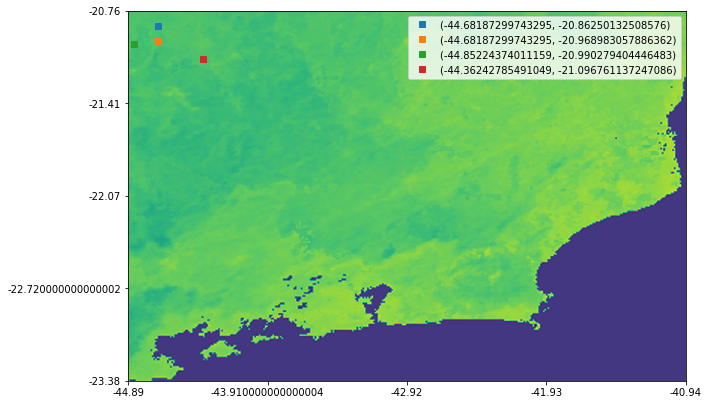

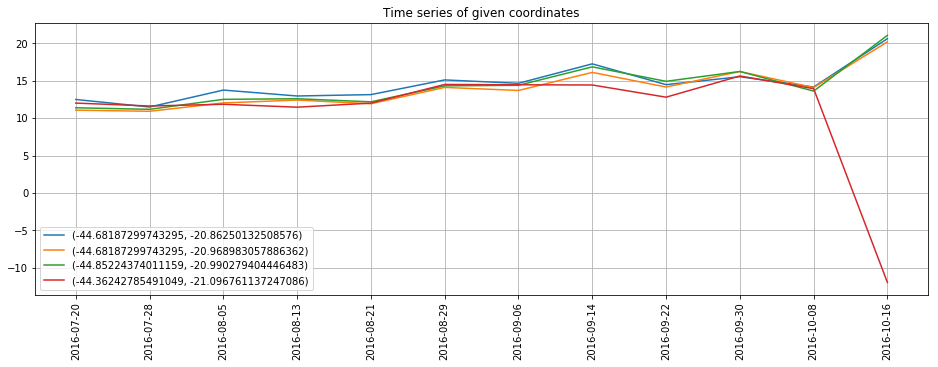

In [12]:
data = rasterio.open("DownloadedFiles/LandDAAC-v5-night-2016-07-20-treated.tiff")
points = [data.transform * [100, 50], 
         data.transform * [100, 100], 
         data.transform * [20, 110], 
         data.transform * [250, 160]]

info = td.point_time_series(points, spatial_coordinates=True)

## 5. Making animations with time series

Sometimes it may be more interesting to visualize a time series as an animation. Here we show how to use our program to make nice animations with little effort. 

### 5.1 Curve animations

Suppose we are interested in studying the temperature and rainfall of a certain city of Rio de Janeiro from 2015-01-01 to 2017-01-01, taking weekly intervals. The first thing we need to do is to construct the data range. Also, just as before, we load the shapefile and make the initial preparations. 

In [4]:
# Extract dates fom date range.
dates = pd.date_range('2015-01-01', '2017-01-01', freq='7D')

In [5]:
# Initial preparation for the downloads.
options = {'plot': False}

Now we download the LST data. Since this source collects data every 8 days, we need to add 1 day in our inervals for each download. 

In [6]:
# Download LST data. 
source1 = 'LandDAAC-v5-day'
for i in range(len(dates)-1):
    # We need an interval of 8 days for the LST data so we add 1 day for each interval.
    date1, date2 = td.timestamp_to_list([dates[i], dates[i+1] + timedelta(days=1)])
    td.download_tiffs(source1, date1, date2, point1, point2, opt=options)

ERROR:root:Download (2015-01-29): failure
ERROR:root:Download (2015-02-05): failure
ERROR:root:Download (2015-02-12): failure
ERROR:root:Download (2015-02-19): failure
ERROR:root:Download (2015-02-26): failure
ERROR:root:Download (2016-01-28): failure
ERROR:root:Download (2016-02-04): failure
ERROR:root:Download (2016-02-11): failure
ERROR:root:Download (2016-02-18): failure
ERROR:root:Download (2016-02-25): failure


The chirps data is collected every day, so we subtract 6 days in our intervals for each download.

In [8]:
# Download rainfall data.
source2 = 'chirps-2.0'
for i in range(len(dates)-1):
    # We need an interval of 1 days for the raninfall data so we subtract 6 days for each interval.
    date1, date2 = td.timestamp_to_list([dates[i], dates[i+1] - timedelta(days=6)])
    td.download_tiffs(source2, date1, date2, point1, point2, opt=options)

All the raster files are downloaded to the same folder which we called *DownloadedFiles* here (you should set your own download path in th file *settings.ini*). After that we separate the files into two folders: *lst* and *rainfall*. This is not necessary but it keep everything more organized. All the paths to the files are stored in the lists *lst_paths* and *rainfall_paths*, respectively.

Notice that some of the LST downloads failed, and we need this data to make the animation. There are lots of ways to deal with this missed data, and here we choosed the simple strategy of just copying the last successful download. 

In [9]:
# For each date we can construct a dataframe with the average pixel for region. 
# We storage these dataframes in dictionaries with the dates as keys. 
lst_path_base = 'DownloadedFiles/lst/LandDAAC-v5-day-'
lst_paths = []
for i in range(len(dates)-1):
    date = td.timestamp_to_list([dates[i]])[0]
    lst_path = lst_path_base + date[0] +  '-' + date[1] +  '-' + date[2] + '.tiff'
    lst_paths.append(lst_path)
    # Verify if this file exists. If not, we make this as a copy of the previous raster.
    exists = os.path.isfile(lst_path)
    if not exists:        
        os.system("cp " + str(lst_paths[-2]) + " " + str(lst_paths[-1]))

In [10]:
# Repeat the same procedure for the rainfall data.
rainfall_path_base = 'DownloadedFiles/rainfall/chirps-v2.0-'
rainfall_paths = []
for i in range(len(dates)-1):
    date = td.timestamp_to_list([dates[i]])[0]
    rainfall_path = rainfall_path_base + date[0] +  '-' + date[1] +  '-' + date[2] + '.tiff'
    rainfall_paths.append(rainfall_path)

Now we join both lists in a list called *raster_paths*. This list gives pointers to the raster files of interest. 

In [11]:
# Make list from the lists of paths.
raster_paths = [lst_paths, rainfall_paths]

Not all data in the animation must be a downloaded raster data, you can use external data. They must by Numpy 1D arrays such that each row correspond to the value of a specific date. The ordering of the rows must follow the same chronological order of the raster files.

In [12]:
# Now we add some synthetic data, representing some extra feature besides the satelite data.
synth1 = 5*np.random.randn(len(dates)-1)
synth2 = np.random.randn(len(dates)-1)

Finally, we call the function **time_series_curve**, which saves the time series as an animation in the current working directory. To see what each options does, see the documentation.

In [13]:
title = 'VOLTA REDONDA: '
region = 'VOLTA REDONDA'
labels = ['LST', 'RAINFALL', 'SYNTHETIC 1', 'SYNTHETIC 2']
shpm.time_series_curve(shp_path, raster_paths, region, title, labels, extra_data=[synth1, synth2], norm=False, framerate=0.5, figsize=[18, 8])

![curve](readme_files/curve.gif "curve")


### 5.3 Map animations

The previous kind of animation when we want to focus on a single region and see several different information of this region at the same time. But sometimes we want to see the big picture. How is this region compared to the others? It is possible to address this question but we need to restrict ourselves to just one feature at time. To illustrate the steps we use the LST data downloaded before.

Remember last plot in section 2, where we made the plot of the average temperature per city of all state of Rio de Janeiro in 2016-07-20. Instead of having the picture of just one day, we can make a series of the same kind of plot. For this we need to transform all LST raster data (downloaded previously) into a single dataframe, where each index correspond to a city and each columns correspond to a date. We can use the function **zonal_means** to accomplish this with little effort, as showed below.

In [14]:
# Construct list with all the arrays of the averages, one for each day.
lst_array_list = []
for i in range(len(lst_paths)):
    z_means = shpm.zonal_means(shp_path, lst_paths[i])
    lst_array_list.append(z_means.values)

In [15]:
# Transform this list into a single dataframe.
lst_df = pd.DataFrame(np.concatenate(lst_array_list, axis=1), index=z_means.index)
# We must change the column labels to the actual dates. If the column labels are not timestamps then 
# we get an error. The last date in dates is never used because we made the downloads in intervals, 
# storing only the first date of the interval.
lst_df.columns = dates[:-1]
lst_df.head()

2015-01-01  2015-01-08  2015-01-15  2015-01-22  2015-01-29  \
PARATI       27.286412   27.286412   28.604339   29.354777   29.354777   
RESENDE      29.627824   29.627824   30.565536   32.717415   32.717415   
ITATIAIA     27.352037   27.352037   28.447367   30.739460   30.739460   
PORTO REAL   32.272329   32.272329   34.263277   36.503099   36.503099   
RIO CLARO    28.561153   28.561153   30.815146   32.796812   32.796812   

            2015-02-05  2015-02-12  2015-02-19  2015-02-26  2015-03-05  ...  \
PARATI       29.354777   29.354777   29.354777   29.354777   22.734433  ...   
RESENDE      32.717415   32.717415   32.717415   32.717415   25.050998  ...   
ITATIAIA     30.739460   30.739460   30.739460   30.739460   23.501459  ...   
PORTO REAL   36.503099   36.503099   36.503099   36.503099   27.837941  ...   
RIO CLARO    32.796812   32.796812   32.796812   32.796812   24.329129  ...   

            2016-10-20  2016-10-27  2016-11-03  2016-11-10  2016-11-17  \
PARATI       26.927996    9.387964   22.584263   25.466948   22.777161   
RESENDE      30.840971   22.825757   27.597525   26.773929   21.390828   
ITATIAIA     28.427086   19.015321   22.840540   23.798957   19.975429   
PORTO REAL   35.371876   29.693143   33.765544   30.545329   23.659961   
RIO CLARO    30.027205   10.340383   28.133138   26.785102   25.408920   

            2016-11-24  2016-12-01  2016-12-08  2016-12-15  2016-12-22  
PARATI        5.522951    5.522951   23.937453    3.981425   24.087207  
RESENDE      13.375613   13.375613   28.335538    3.227876   25.259869  
ITATIAIA      8.793888    8.793888   24.650885   10.122488   24.040676  
PORTO REAL   29.293445   29.293445   31.201441   -7.437730   28.788167  
RIO CLARO    15.954490   15.954490   26.240891    4.536553   24.787097  

[5 rows x 104 columns]

The important data you should have is this last dataframe and the shapefile. The procedure we conducted here to produce this dataframe is just an example, but feel free to produce it in other ways.

In [16]:
# Now we can create the animated map.
title = 'Temperatura média do Rio de Janeiro: '
shpm.time_series_map(shp_path, lst_df, title, framerate=0.5, cmap='Reds')

![map](readme_files/map.gif "map")

## 6. Learning about the sources and options

Call the function **about**, first with the input 'sources', and them with the input 'options'. This function shows the relevant information about all the sources and options we have at our disposal.

In [17]:
td.about('sources')

LandDAAC-v5-day
---------------
Day LST from USGS LandDAAC MODIS 1km 8day version_005 Terra SSA: Day and Night Land Surface Temperature of Southern South America.
Time: grid: /T (days since 2003-01-01) ordered [ (5-12 Mar 2000) (13-20 Mar 2000) (21-28 Mar 2000) ... (22-29 Mar 2017)] N= 785 pts :grid
Longitude: grid: /X (degree_east) ordered (77.99467W) to (40.002W) by 0.01064817 N= 3569 pts :grid
Latitude: grid: /Y (degree_north) ordered (20.00532S) to (56.99707S) by 0.01064817 N= 3475 pts :grid
Link: https://iridl.ldeo.columbia.edu/SOURCES/.USGS/.LandDAAC/.MODIS/.1km/.8day/.version_005/.Terra/.SSA/.Day/.LST/

LandDAAC-v5-night
-----------------
Night LST from USGS LandDAAC MODIS 1km 8day version_005 Terra SSA: Day and Night Land Surface Temperature of Southern South America.
Time: grid: /T (days since 2003-01-01) ordered [ (5-12 Mar 2000) (13-20 Mar 2000) (21-28 Mar 2000) ... (22-29 Mar 2017)] N= 785 pts :grid
Longitude: grid: /X (degree_east) ordered (77.99467W) to (40.002W) by 0.010

In [18]:
td.about('options')

cmap (string)
-------------
The name of the colormap to use when plotting images. Default is `jet`.

regrid (list)
-------------
When downloading the images you also have the option to make a downsampling or upsampling over all the images and download these new pack of images. You should pass a list of two items. The first is a positive float, the ratio of the regrid. For example, if the original image is 120x120 and regrid[0]=2, them the program will create a image of shape 240x240. The second is the method of the resampling, which can be `nearest`, `average`, `bilinear`, `cubic`, `cubic_spline`, `mode`, `lanczos`, `max`, `min`,`q1` and `q3`.
Link: https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py#L28

plot (bool)
-----------
When this option is set to True the program plots each one of the images downloaded. At the moment this only works when some regrid is done. Default is False.

keep_original (bool)
--------------------
When this option is set to True (default) the 